# Urban Density Comparison

## Angkor

### Libraries

In [121]:
# Libraries
# core
import numpy as np
import pandas as pd
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# chronocluster
from chronocluster.data.dataio import pts_df_to_gis, kde_to_geotiff
from chronocluster import clustering
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, get_box, chrono_plot, draw_ellipses
from chronocluster.distributions import ddelta
from chronocluster.density import kde_time, custom_kde, pymc_gmm_peak_finder, kde_peaks, rank_peaks

### Data Wrangling

In [122]:
# data wrangling
df = pd.read_csv('../Data/temples_with_predicted_ages.csv')
df = df.dropna(subset=['xeast', 'ynorth', 'model_age_mean'])
df

,Unnamed: 0,id,morph,azimuth,area,trait_1,trait_2,trait_3,trait_4,trait_5,...,date,dating_notes,xlong,ylat,date_type,xeast,ynorth,date_emp,model_age_mean,model_age_sd
0,1,876,square,90.424247,90.860298,False,False,True,False,True,...,995.0,Date derived from art historical analyses of l...,103.85821,13.42621,empirical,376391.1,1484555.0,995.0,995.000000,0.000000
1,2,874,square,90.000000,121.102386,False,False,False,False,True,...,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376029.9,1484559.0,889.0,889.000000,0.000000
2,3,878,square,90.000000,144.909427,False,False,True,False,True,...,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376568.1,1484474.0,889.0,889.000000,0.000000
3,4,933,square,90.000000,182.458280,False,False,True,False,False,...,1115.0,Temple is included in the CCC,NaN,NaN,empirical,377453.2,1486464.0,1115.0,1115.000000,0.000000
4,5,973,square,90.658658,185.512325,False,False,NaN,NaN,NaN,...,1002.0,Temple is included in the CCC during Period 3.,NaN,NaN,empirical,377851.6,1486810.0,1002.0,1002.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,1388,6996,NaN,NaN,NaN,NaN,NaN,True,False,True,...,1166.0,Date derived through graph-based semi-supervis...,103.77332,13.37078,graphbased,367166.2,1478474.0,NaN,1060.857255,157.749918
1388,1389,7001,NaN,NaN,NaN,NaN,NaN,False,False,False,...,848.0,Date derived through graph-based semi-supervis...,103.94124,13.36301,graphbased,385365.8,1477530.0,NaN,891.133185,156.131874
1389,1390,7002,NaN,NaN,NaN,NaN,NaN,True,False,False,...,934.0,Date derived through graph-based semi-supervis...,103.89110,13.33931,graphbased,379910.8,1474927.0,NaN,911.943782,157.864667
1391,1392,7005,NaN,NaN,NaN,NaN,NaN,True,False,True,...,1166.0,Date derived through graph-based semi-supervis...,103.94205,13.35556,graphbased,385420.9,1476712.0,NaN,1059.497828,157.196025


#### Create Points List

In [123]:
points = [
    clustering.Point(
        x=row['xeast'],
        y=row['ynorth'],
        start_distribution = (
            ddelta(d=row['model_age_mean']) 
            if row['model_age_sd'] == 0 
            else norm(loc=row['model_age_mean'], scale=row['model_age_sd'])
            ),
        end_distribution = ddelta(1500)
    )
    for _, row in df.iterrows()
]

# just double check the first ten look right
points[:10]

[Point(x=376391.1, y=1484555.0, start_distribution=ddelta(d=995.0), end_distribution=ddelta(d=1500)),
 Point(x=376029.9, y=1484559.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=376568.1, y=1484474.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=377453.2, y=1486464.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377851.6, y=1486810.0, start_distribution=ddelta(d=1002.0), end_distribution=ddelta(d=1500)),
 Point(x=377220.5, y=1487538.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377181.0, y=1487114.0, start_distribution=norm(loc=968.834803750701, scale=167.354175823925), end_distribution=ddelta(d=1500)),
 Point(x=377328.8, y=1486122.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=375082.2, y=1487158.0, start_distribution=norm(loc=968.613504981728, scale=167.63665988916), end_distribution=ddelta(d=1500)),
 Point(x=

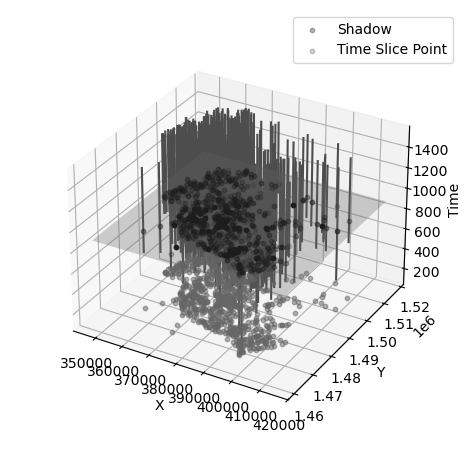

In [124]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=900)
ax.set_box_aspect(None, zoom=0.85)

#### Define Time Slices

In [125]:
# Define the time slices
start_time = 800
end_time = 1200
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)
time_slices

array([ 800,  850,  900,  950, 1000, 1050, 1100, 1150])

#### GPU Boosted Pairwise Distance Density KDEs

In [126]:
from cuml.neighbors import KernelDensity

def cuml_kde(distances, bandwidth, **kwargs):
    distances = np.array(distances).reshape(-1, 1)

    if bandwidth is None:
        n = len(distances)
        if n < 2:
            raise ValueError("Data must contain at least 2 points for bandwidth calculation.")
        std_dev = np.std(distances, ddof=1)  # Sample standard deviation
        bandwidth = std_dev * n ** (-1 / 5)
    
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth, **kwargs)
    kde.fit(distances)

    def kde_function(points):
        points = np.array(points).reshape(-1, 1)
        # score_samples returns a cupy array; use .get() to convert to NumPy
        return np.exp(kde.score_samples(points).get())  # Return densities as a NumPy array
    
    return kde_function

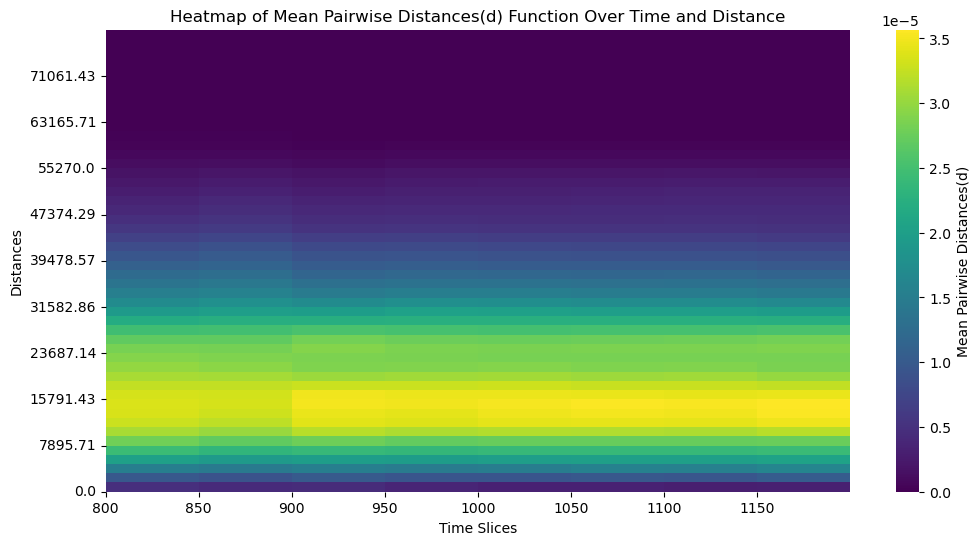

In [127]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 500 # sets the number of draws for incorporating chronological uncertainty
simulations = clustering.mc_samples(points, 
                                    time_slices=time_slices,  
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)
use_kde = True
pair_bw = None
kde_sample_n = 50
kde_custom=cuml_kde

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices,
                                                         bw=pair_bw, 
                                                         use_kde=use_kde, 
                                                         kde_sample_n=kde_sample_n,
                                                         max_distance=max_distance,
                                                         kde_custom=kde_custom)

# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')


#### Complete Spatial Randomness

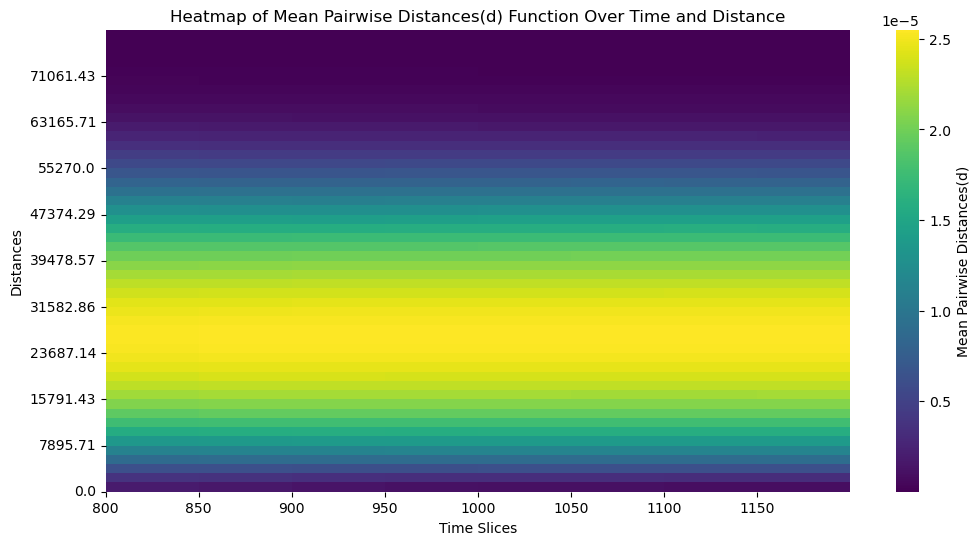

In [128]:
# Get MC iterations for incorporating chronological uncertainty and CSR
csr_simulations = clustering.mc_samples(points, 
                                        time_slices = time_slices,  
                                        num_iterations = num_iterations,
                                        null_model=clustering.csr_sample,
                                        x_min=x_min, 
                                        x_max=x_max,
                                        y_min=y_min, 
                                        y_max=y_max)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

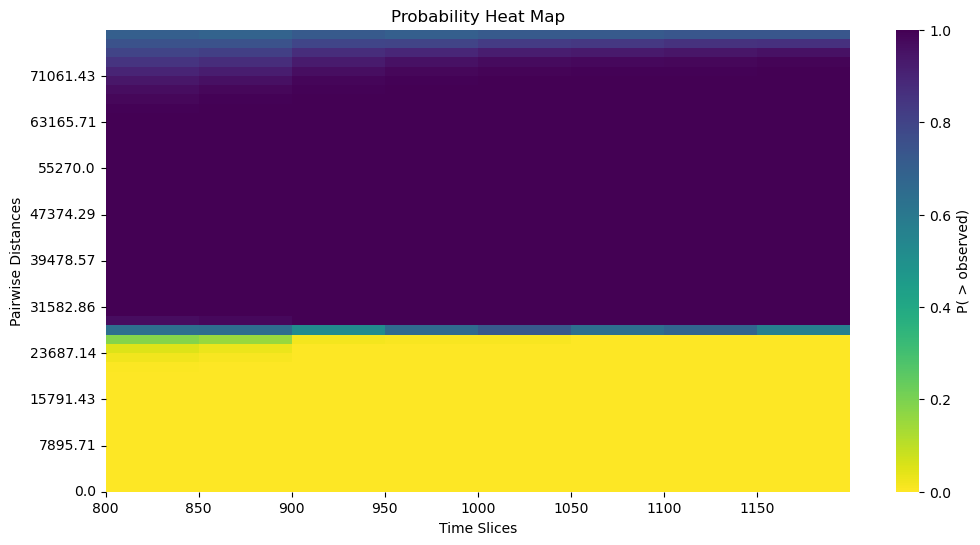

In [129]:
# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)

#### Baseline-Informed Spatial Expectation

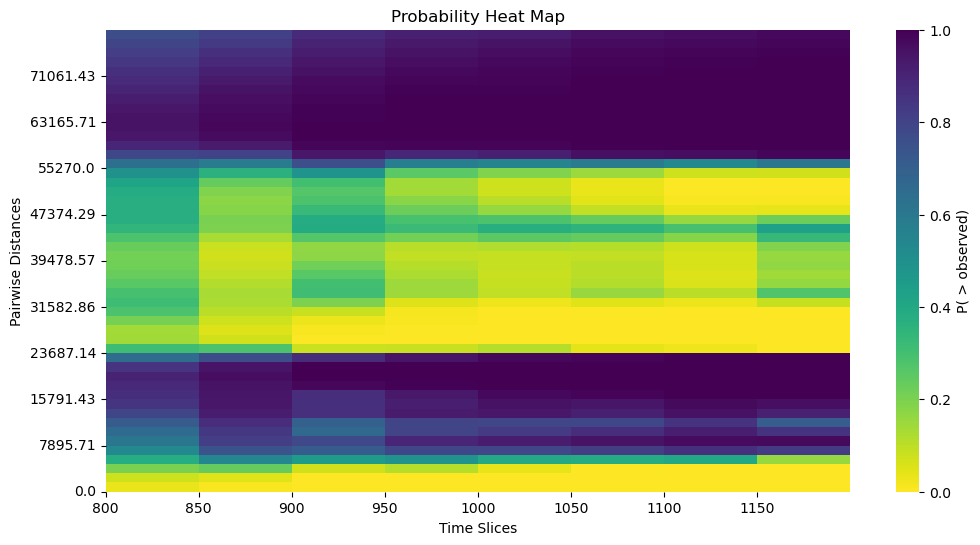

In [130]:
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(points, 
                                         time_slices, 
                                         num_iterations=num_iterations,
                                         null_model=clustering.bise)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density, bise_support = clustering.temporal_pairwise(bise_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, bise_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              bise_support)

#### One Time Slice

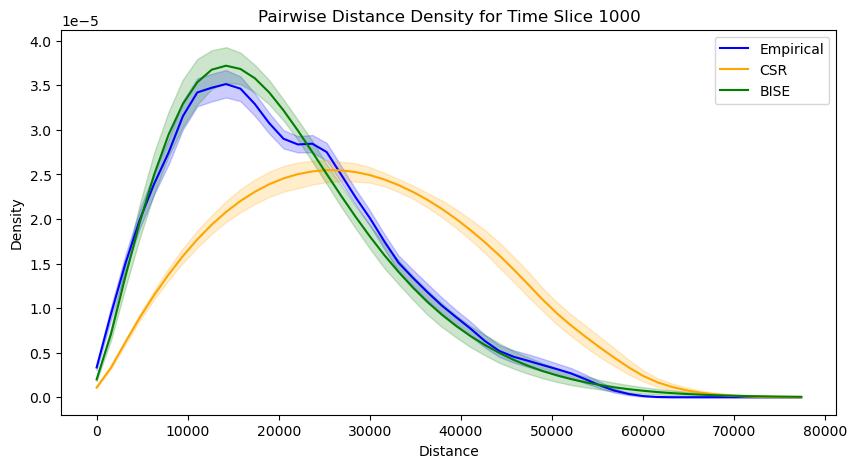

In [131]:
from chronocluster.utils import plot_pdd

time_slice_idx = np.where(time_slices == 1000)[0][0]  # corresponding to time 1100

# List of density arrays
density_arrays = [pairwise_density, csr_pairwise_density, bise_pairwise_density]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "CSR", "BISE"],
    colors=["blue", "orange", "green"]
)

# Show the plot
plt.show()

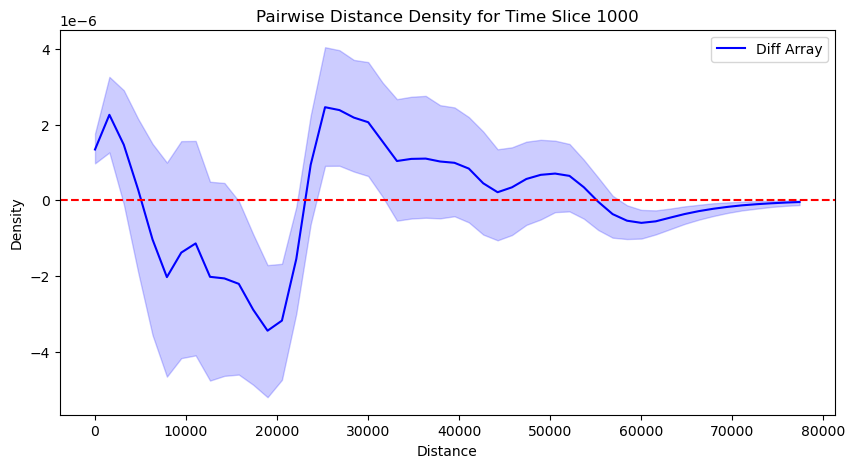

In [132]:
# List of density arrays
density_arrays = [diff_array]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Diff Array"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Show the plot
plt.show()

#### Series of Slices

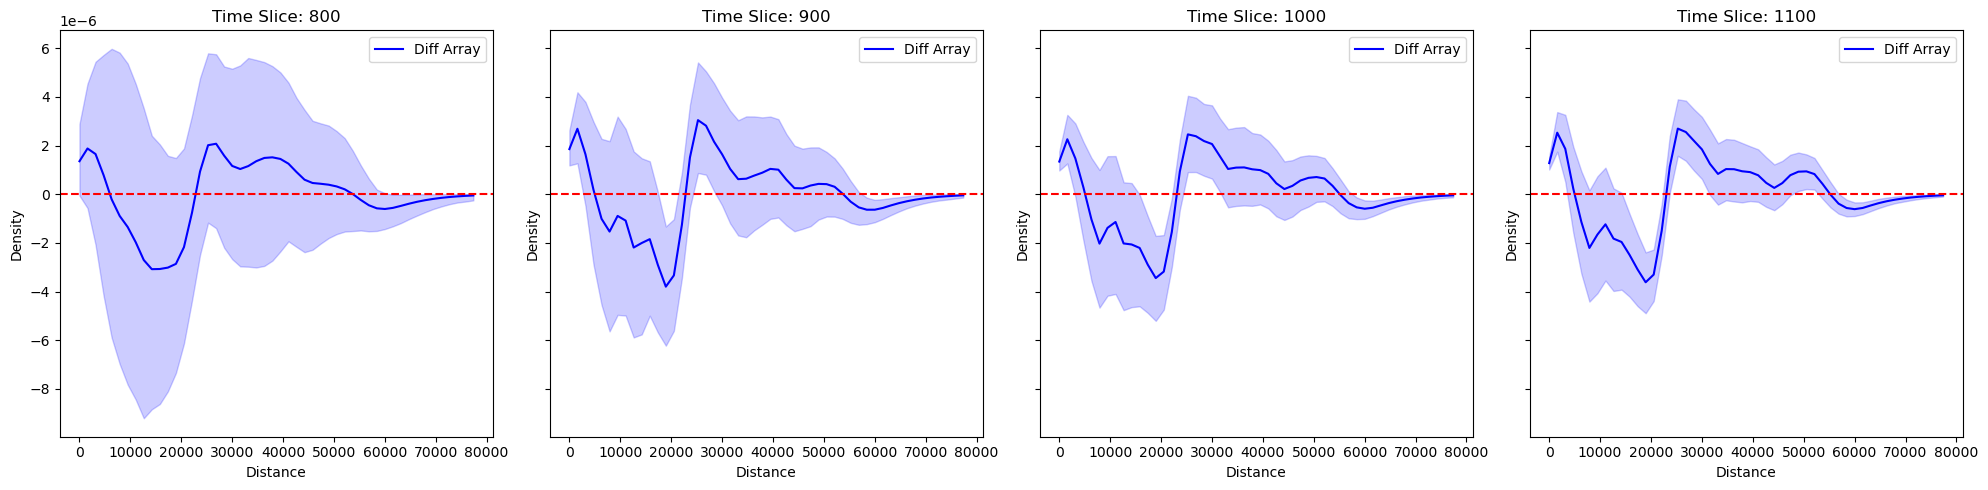

In [133]:
# List of time_slice_idx values
time_slice_indices = [0, 2, 4, 6]

# Create a figure and axes for subplots
num_panels = len(time_slice_indices)
fig, axes = plt.subplots(1, num_panels, figsize=(5 * num_panels, 5), sharey=True)  # 1 row, multiple columns

# Loop through each time_slice_idx and generate the plots
for idx, (ax, time_slice_idx) in enumerate(zip(axes, time_slice_indices)):
    # Generate the plot for the current time_slice_idx
    fig, _ = plot_pdd(
        time_slices=time_slices,
        time_slice_idx=time_slice_idx,
        support=support,
        density_arrays=density_arrays,
        quantiles=[0.025, 0.975],
        density_names=["Diff Array"],
        colors=["blue"],
        ax=ax
    )
    
    # Add a horizontal line (optional)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    
    # Add a title for each panel
    ax.set_title(f"Time Slice: {time_slices[time_slice_idx]}")

# Adjust layout and show the stitched plot
plt.tight_layout()
plt.show()

In [134]:
# Define grid resolution and create the 2D grid for KDE evaluation
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

grid_resolution = 100  # Adjust the number of points as needed for resolution
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
grid = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T  # Flatten the grid for KDE input

#### Temporally-Weighted Spatial KDE

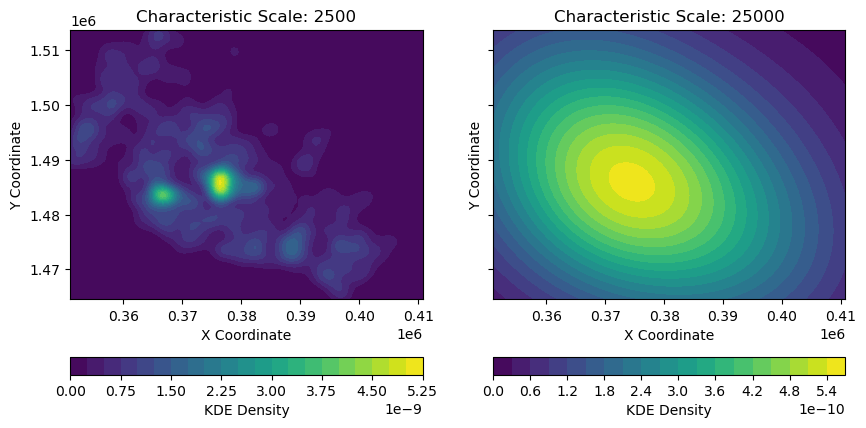

In [135]:
# identify and save one or more characteristic scales
characteristic_scales = [2500, 25000]

# Set time_slice
time_slice = time_slices[6]

# Create a figure and axes for subplots
num_panels = len(characteristic_scales)
fig, axes = plt.subplots(1, num_panels, figsize=(5 * num_panels, 5), sharey=True)  # 1 row, multiple columns

# Pre-calculate KDE values to determine the global color scale
kde_values_list = []
for characteristic_scale in characteristic_scales:
    bandwidth =  characteristic_scale * 0.5
    kde_values = kde_time(points, 
                          time_slice, 
                          bandwidth, 
                          grid, 
                          output_shape=x_mesh.shape, 
                          kde_method=custom_kde)
    kde_values_list.append(kde_values)

# Plot each kde using the shared color scale
for i, (characteristic_scale, kde_values) in enumerate(zip(characteristic_scales, kde_values_list)):
    # Plot KDE on the corresponding subplot
    ax = axes[i]
    contour = ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Characteristic Scale: {characteristic_scale}")

    # Set scientific notation for both axes
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((6, 6))
    
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((6, 6))

    # Add individual colorbar for each plot
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.15)
    cbar.set_label("KDE Density")

# show plot
plt.show()

#### Series of Temporally-Weighted Spatial KDEs

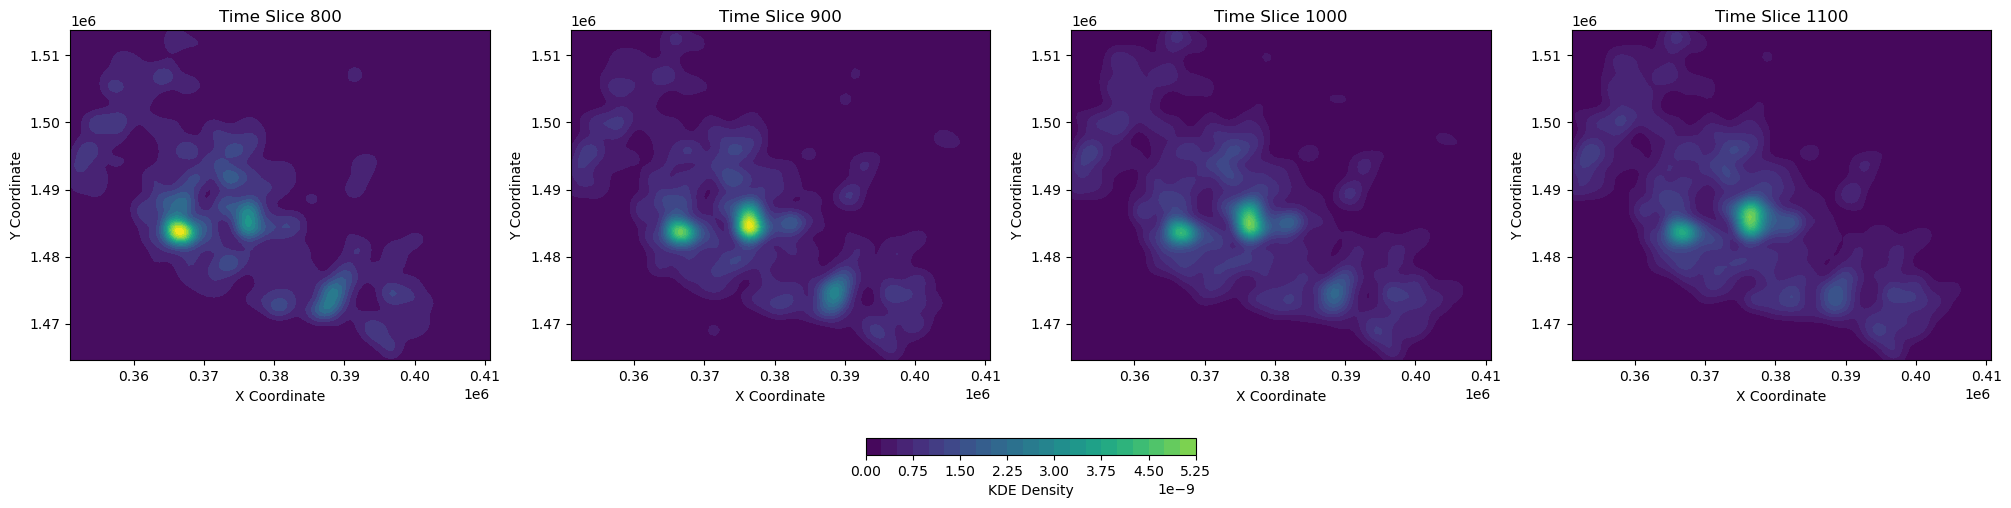

In [136]:
# define bandwidth for spatial KDE
bandwidth = characteristic_scales[0] * 0.5

# Select the indices of the time slices you want to plot (4 slices)
time_slice_indices = [0, 2, 4, 6]

# Pre-calculate KDE values to determine the global color scale
kde_values_list = []
for time_slice_idx in time_slice_indices:
    time_slice = time_slices[time_slice_idx]
    kde_values = kde_time(points, 
                          time_slice, 
                          bandwidth, 
                          grid, 
                          output_shape=x_mesh.shape, 
                          kde_method=custom_kde)
    kde_values_list.append(kde_values)

# Determine global min and max for the color scale
vmin = np.min([np.min(kde) for kde in kde_values_list])
vmax = np.max([np.max(kde) for kde in kde_values_list])

# Create subplots with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

# Plot each time slice using the shared color scale
for i, (time_slice_idx, kde_values) in enumerate(zip(time_slice_indices, kde_values_list)):
    time_slice = time_slices[time_slice_idx]
    
    # Plot KDE on the corresponding subplot
    ax = axes[i]
    contour = ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Time Slice {time_slice}")

    # Set scientific notation for both axes
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((6, 6))
    
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((6, 6))

# Add a single shared colorbar
cbar = fig.colorbar(contour, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("KDE Density")

# Display the plots
plt.show()


In [137]:
kde_to_geotiff(x_mesh, 
               y_mesh, 
               kde_values, 
               epsg_code=32648, 
               output_path="../Output/angkor_temples_kde_output.tif")

GeoTIFF saved as ../Output/angkor_temples_kde_output.tif


#### Saved Angkor PDD Difference Plot

In [138]:
# Priors for spatial scale (variance) based on pairwise distance density analysis
target_scale = characteristic_scales[0] * 0.5  # This is our target spatial scale for each component
target_scale_sd = 1000  # Some variation around this value to reflect uncertainty

# which corresponds to this portion of the PDD at the corresponding time slice

# Generate the plot and get the figure and axis objects
fig_pdd_angkor, ax_pdd_angkor = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Diff Array"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax_pdd_angkor.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_pdd_angkor.axvline(x=characteristic_scales[0], color = 'grey', linestyle='-', linewidth=1.5)
ax_pdd_angkor.axvline(x=characteristic_scales[0] + target_scale_sd, color = 'grey', linestyle='--', linewidth=1.5)
ax_pdd_angkor.axvline(x=characteristic_scales[0] - target_scale_sd, color = 'grey', linestyle='--', linewidth=1.5)

# Save figure and close
saved_fig_angkor = fig_pdd_angkor
plt.close(fig_pdd_angkor)

# Show the plot
#plt.show()

DUNNO ABOUT WHETHER TO DO THE FOLLOWING FOR THIS PAPER OR LEAVE IT FOR ANOTHER PAPER

In [ ]:
# Identify spatial density peaks
# Calculate the spatial extent based on bounding box to constrain the prior for
# the component means (parameter space outside this area is going to be fruitless)
bounding_box_variance = ( max_distance / 2)**2

# Set maximum number of components to allow in the model
max_components = 8
w_threshold = 1 / max_components # used for idenitifying peak importance

# Run kde_peaks with GMM as the peak-finding method
# Assuming coordinates is your dataset of temple locations, passed as Point objects
peaks, weights, trace = kde_peaks(points=points, 
                                    num_peaks=max_components, 
                                    peak_finder=pymc_gmm_peak_finder,
                                    time_slice = time_slice,
                                    target_scale = target_scale,
                                    target_scale_sd = target_scale_sd,
                                    w_threshold = w_threshold,
                                    sampler = 'NUTS',
                                    draws = 2000,
                                    tune = 4000,
                                    chains = 1)

In [ ]:
importance_hdi = 0.80
summary_df = rank_peaks(trace, significance=importance_hdi, source_param='importance')

# isolate important peaks
# Filter rows where the lower bound of the HDI is greater than importance_threshold
importance_threshold = 0
condition = summary_df[f'{int(importance_hdi * 100)}% HDI (Importance)'].apply(lambda hdi: hdi[0] > importance_threshold)
important_peaks = summary_df[condition] # isloated for plotting below
summary_df

In [ ]:
pts_df_to_gis(summary_df,
              epsg_code=32648,
              output_path="../Output/angkor_temple_cluster_centres.gpkg", 
              file_format="GPKG")

In [ ]:
# Plotting
fig, ax = plt.subplots()

# Plot KDE density surface
ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')

# Extract the X and Y coordinates from the Coordinates column for plotting
x_coords = important_peaks['Coordinates'].apply(lambda coord: coord[0])
y_coords = important_peaks['Coordinates'].apply(lambda coord: coord[1])

# Plot the original data points
#ax.scatter(summary_df['x'], summary_df['y'], color='white', marker='o', s=5, label='Original Data')

# Draw ellipses for the GMM components with 1 SD and 2 SD ranges
draw_ellipses(ax, 
              important_peaks, 
              std_devs=[1, 2], 
              edgecolor='red', 
              facecolor='none', 
              linestyle='--', 
              linewidth=1)

# Annotate each component with its rank
for x, y, rank in zip(x_coords, y_coords, important_peaks['Rank']):
    ax.text(x, y, rank, color='black', ha='center', va='center', fontsize=12)

# Add legend, labels, and title
ax.legend()
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("KDE with GMM Peaks Ranked by Importance")

plt.show()

## Hampshire County at Doomsday

### Data Wrangling

In [139]:
# data wrangling
doomsday_places = pd.read_csv('../Data/doomsday_places.csv')
doomsday_places = doomsday_places.dropna(subset=['easting', 'northing'])
doomsday_places

,PlacesIdx,County,Phillimore,Hundred,Vill,Area,XRefs,OSrefs,OScodes,lat,lon,easting,northing,start_date,end_date
0,1,WOR,"15,8",`Doddingtree',Abberley,NaN,NaN,SO7567,NaN,52.300561,-2.368032,375000.0,267000.0,1066,1086
1,6,ESS,"20,20. 24,51. 34,16",`Winstree',Abberton,NaN,NaN,TL9919,NaN,51.834157,0.886905,599000.0,219000.0,1066,1086
2,11,WOR,"9,1a",Pershore,Abberton,NaN,NaN,SO9953,NaN,52.175269,-2.016034,399000.0,253000.0,1066,1086
3,16,DOR,"13,1",`Uggescombe',Abbotsbury,NaN,NaN,SY5785,NaN,50.663064,-2.609752,357000.0,85000.0,1066,1086
4,21,DEV,"5,6",Merton,Abbotsham,NaN,NaN,SS4226,NaN,51.011615,-4.253705,242000.0,126000.0,1066,1086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13453,73861,STS,"2,22",Offlow,Yoxall,NaN,NaN,SK1419,NaN,52.768434,-1.793938,414000.0,319000.0,1066,1086
13454,73866,SUF,"7,18. 44,4",`Blything',Yoxford,NaN,NaN,TM3968,NaN,52.258228,1.500634,639000.0,268000.0,1066,1086
13455,73871,CHS,"FT1,4",Ati's Cross,Ysceifiog,Ati's Cross,NaN,SJ1571,NaN,53.229229,-3.274776,315000.0,371000.0,1066,1086
13456,73876,DEV,"6,3",North Tawton,Zeal Monachorum,NaN,NaN,SS7103,NaN,50.812135,-3.832415,271000.0,103000.0,1066,1086


Includes removing two problematic points in the data with a likely incorrect county labels.

In [140]:
# isolating Hampshire for comparison with Angkor
counties = ['HAM']
doomsday_df = doomsday_places[doomsday_places['County'].isin(counties)]

# I know there is a probable county designation error for the following point 
# (observed in QGIS as an kind of spatial outlier surrounded by points  with a 
# different designation and appears to be a duplicate point where the alternate 
# one has the same county designation as the other surrounding points)

# PlacesIdx of the mislabelled point is 10221 while the alternate is 10226
drop_idx = doomsday_df[doomsday_df['PlacesIdx'].isin([10221, 30086])].index
doomsday_df = doomsday_df.drop(drop_idx)

### Create Points List

In [141]:
doomsday_points = [
    clustering.Point(
        x=row['easting'],
        y=row['northing'],
        start_distribution = ddelta(1066),
        end_distribution = ddelta(1086)
    )
    for _, row in doomsday_df.iterrows()
]

# just double check the first ten look right
doomsday_points[:10]

[Point(x=456000.0, y=134000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=458000.0, y=88000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=459000.0, y=86000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=435000.0, y=86000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=456000.0, y=83000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=447000.0, y=117000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=427000.0, y=107000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=458000.0, y=133000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=471000.0, y=139000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=460000.0, y=98000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086))]

### Define Time Slices and Spatial Limits

In [142]:
# Define the time slices
start_time = 1066
end_time = 1086
time_interval = 5
time_slices = np.arange(start_time, end_time, time_interval)
time_slices

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(doomsday_points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

In [143]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations = clustering.mc_samples(doomsday_points, 
                                    time_slices=time_slices,  
                                    num_iterations=num_iterations)


### Sampling and Pairwise Distance Density Estimation

In [144]:
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(doomsday_points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)
# same as before with Angkor data

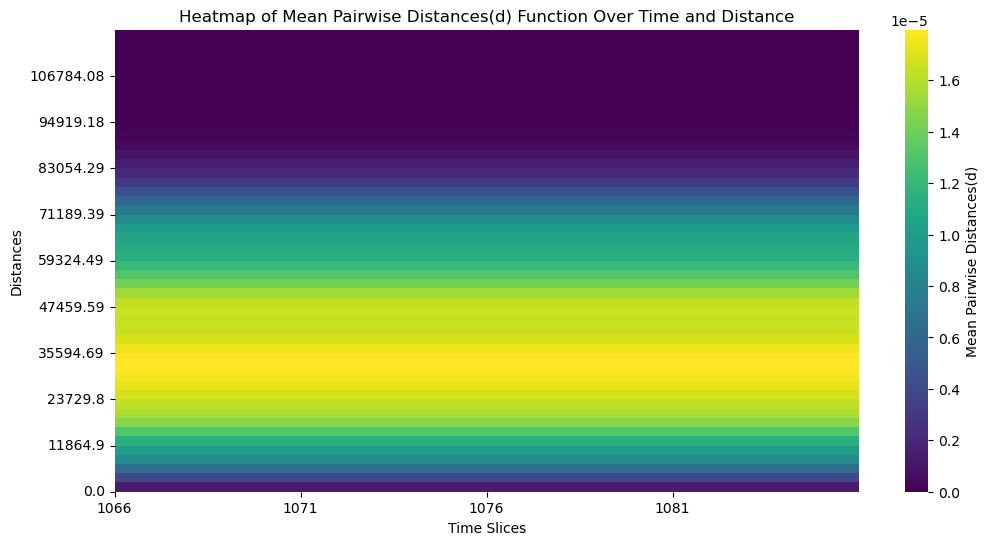

In [145]:
# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=pair_bw, 
                                                         use_kde=use_kde, 
                                                         kde_sample_n=kde_sample_n,
                                                         max_distance=max_distance,
                                                         kde_custom=kde_custom)

# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

#### Complete Spatial Randomness

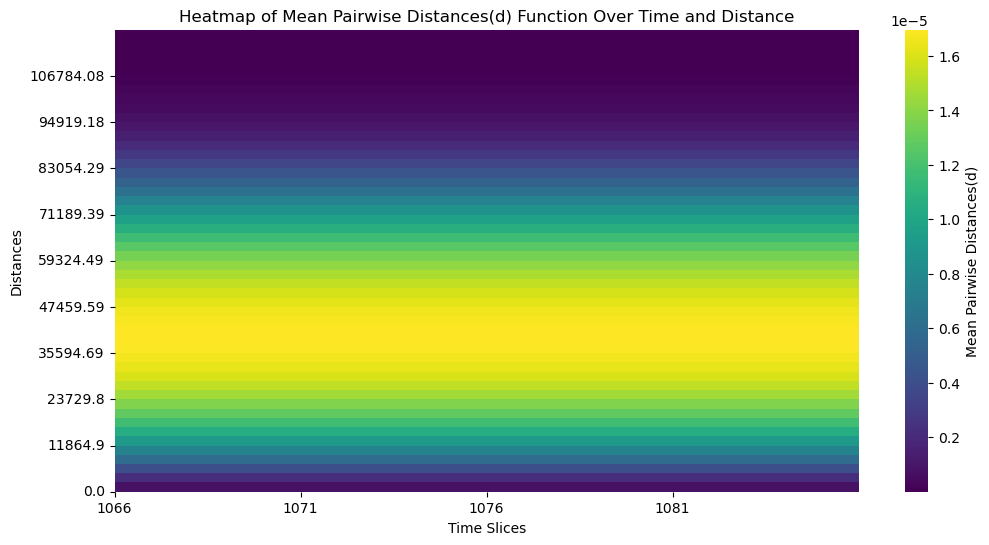

In [147]:
# Get MC iterations for incorporating chronological uncertainty and CSR
csr_simulations = clustering.mc_samples(doomsday_points, 
                                        time_slices = time_slices,  
                                        num_iterations = num_iterations,
                                        null_model=clustering.csr_sample,
                                        x_min=x_min, 
                                        x_max=x_max,
                                        y_min=y_min, 
                                        y_max=y_max)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

#### Baseline-Informed Spatial Expectation

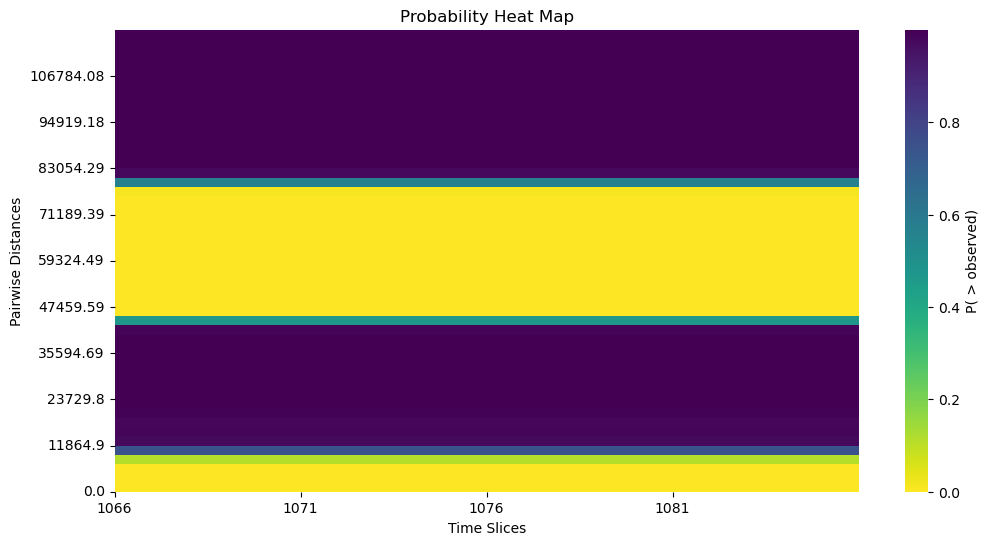

In [148]:
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(doomsday_points, 
                                         time_slices, 
                                         num_iterations=num_iterations,
                                         null_model=clustering.bise)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density, bise_support = clustering.temporal_pairwise(bise_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, bise_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              bise_support)

#### One Time Slice

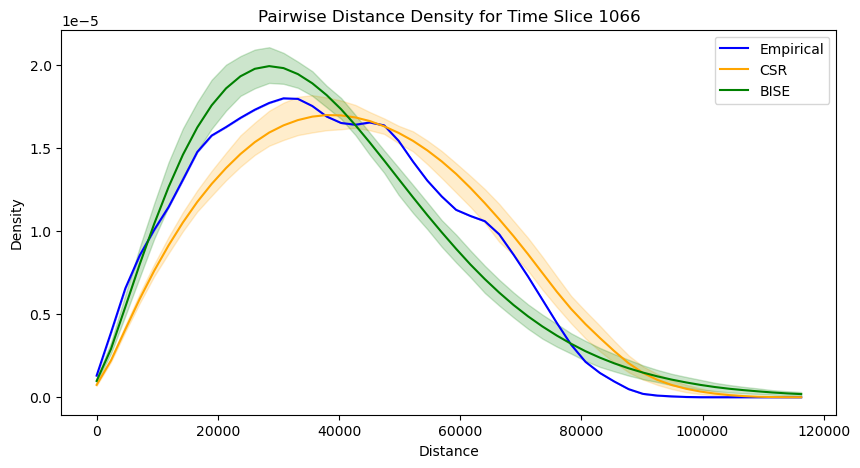

In [151]:
#from chronocluster.utils import plot_pdd
time_slice_idx = np.where(time_slices == 1066)[0][0]

# List of density arrays
density_arrays = [pairwise_density, csr_pairwise_density, bise_pairwise_density]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "CSR", "BISE"],
    colors=["blue", "orange", "green"]
)

# Show the plot
plt.show()

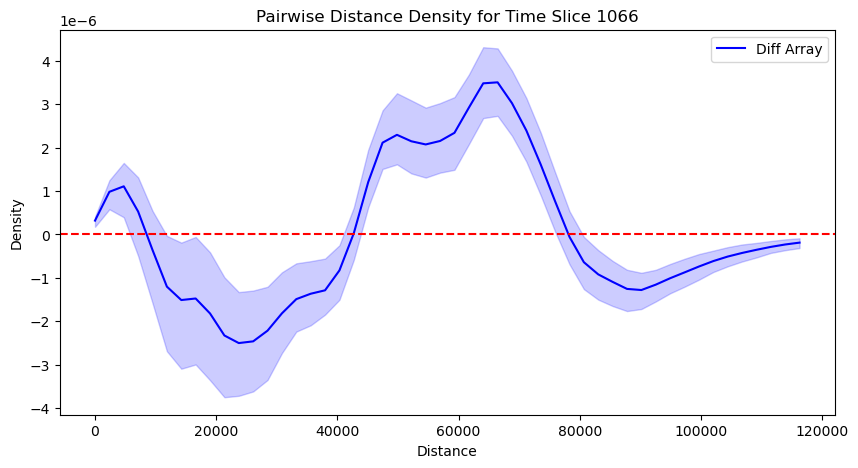

In [152]:
# List of density arrays
density_arrays = [diff_array]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Diff Array"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Show the plot
plt.show()

#### Temporally-Weighted Spatial KDE

In [153]:
grid_resolution = 100  # Adjust the number of points as needed for resolution
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
grid = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T  # Flatten the grid for KDE input

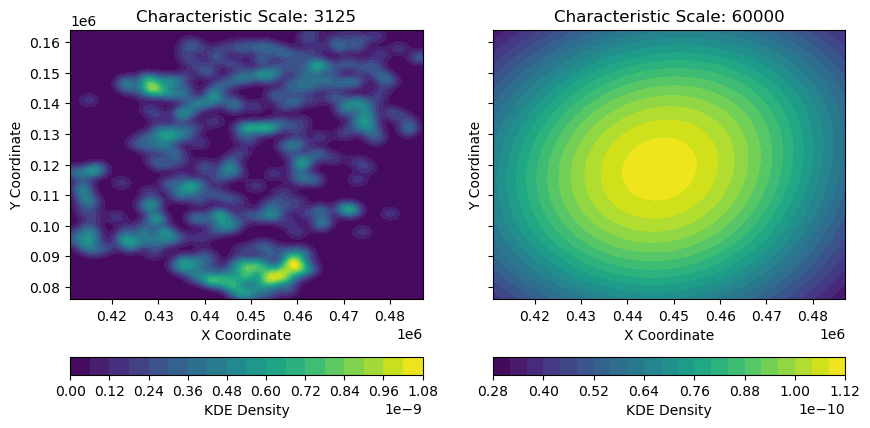

In [154]:
# identify and save one or more characteristic scales
characteristic_scales = [3125, 60000]

# Set time_slice
time_slice = time_slices[time_slice_idx]

# Create a figure and axes for subplots
num_panels = len(characteristic_scales)
fig, axes = plt.subplots(1, num_panels, figsize=(5 * num_panels, 5), sharey=True)  # 1 row, multiple columns

# Pre-calculate KDE values to determine the global color scale
kde_values_list = []
for characteristic_scale in characteristic_scales:
    bandwidth =  characteristic_scale * 0.5
    kde_values = kde_time(doomsday_points, 
                          time_slice, 
                          bandwidth, 
                          grid, 
                          output_shape=x_mesh.shape, 
                          kde_method=custom_kde)
    kde_values_list.append(kde_values)

# Plot each kde using the shared color scale
for i, (characteristic_scale, kde_values) in enumerate(zip(characteristic_scales, kde_values_list)):
    # Plot KDE on the corresponding subplot
    ax = axes[i]
    contour = ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Characteristic Scale: {characteristic_scale}")

    # Set scientific notation for both axes
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((6, 6))
    
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((6, 6))

    # Add individual colorbar for each plot
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.15)
    cbar.set_label("KDE Density")

# show plot
plt.show()

#### Save PDD Plot for Hampshire

In [155]:
# Priors for spatial scale (variance) based on pairwise distance density analysis
target_scale = characteristic_scales[0] * 0.5  # This is our target spatial scale for each component
target_scale_sd = 1000  # Some variation around this value to reflect uncertainty

# which corresponds to this portion of the PDD at the corresponding time slice

# Generate the plot and get the figure and axis objects
fig_pdd_dooms, ax_pdd_dooms = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Diff Array"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax_pdd_dooms.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_pdd_dooms.axvline(x=characteristic_scales[0], color = 'grey', linestyle='-', linewidth=1.5)
ax_pdd_dooms.axvline(x=characteristic_scales[0] + target_scale_sd, color = 'grey', linestyle='--', linewidth=1.5)
ax_pdd_dooms.axvline(x=characteristic_scales[0] - target_scale_sd, color = 'grey', linestyle='--', linewidth=1.5)

# Save figure and close
saved_fig_dooms = fig_pdd_dooms
plt.close(fig_pdd_dooms)

# Show the plot
#plt.show()

## Combine PDD Time Slice Plots for Comparison

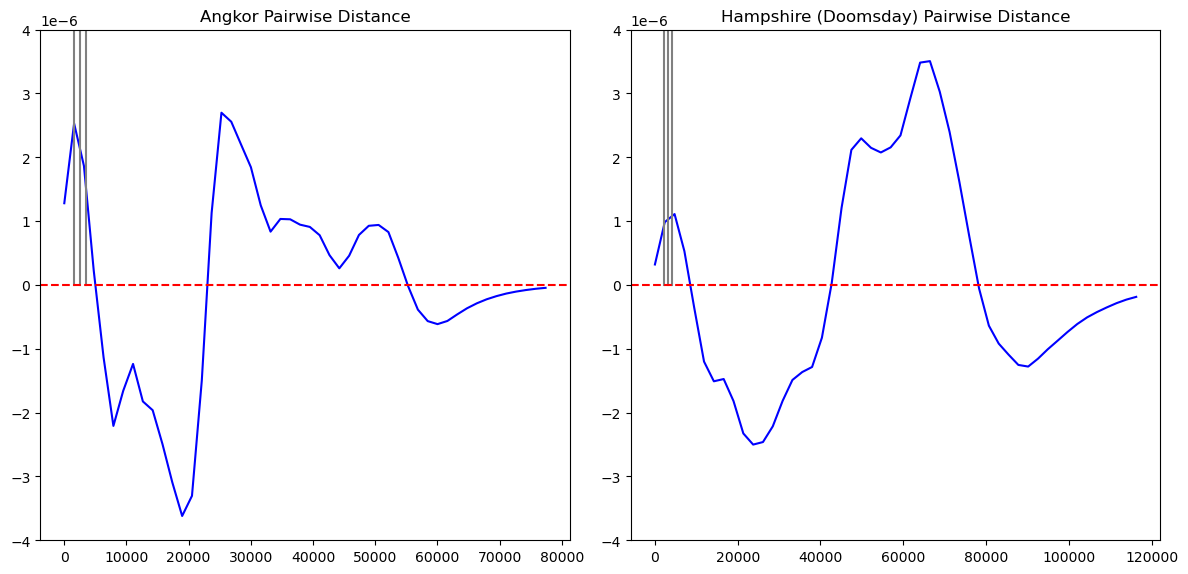

In [159]:
from matplotlib.gridspec import GridSpec

# Create a new figure for combining
combined_pdd_fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, figure=combined_pdd_fig)

# Add the first plot to the new figure
ax_combined_1 = combined_pdd_fig.add_subplot(gs[0, 0])
for line in saved_fig_angkor.axes[0].get_lines():
    ax_combined_1.plot(line.get_xdata(), line.get_ydata(), color=line.get_color())
ax_combined_1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_combined_1.set_title("Angkor Pairwise Distance")
ax_combined_1.set_ylim([-4e-6, 4e-6])  # Set y-axis limits

# Add the second plot
ax_combined_2 = combined_pdd_fig.add_subplot(gs[0, 1])
for line in saved_fig_dooms.axes[0].get_lines():
    ax_combined_2.plot(line.get_xdata(), line.get_ydata(), color=line.get_color())
ax_combined_2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_combined_2.set_title("Hampshire (Doomsday) Pairwise Distance")
ax_combined_2.set_ylim([-4e-6, 4e-6])  # Set y-axis limits

# Display the combined figure
plt.tight_layout()
plt.show()

### Scaled for Transportation Differences

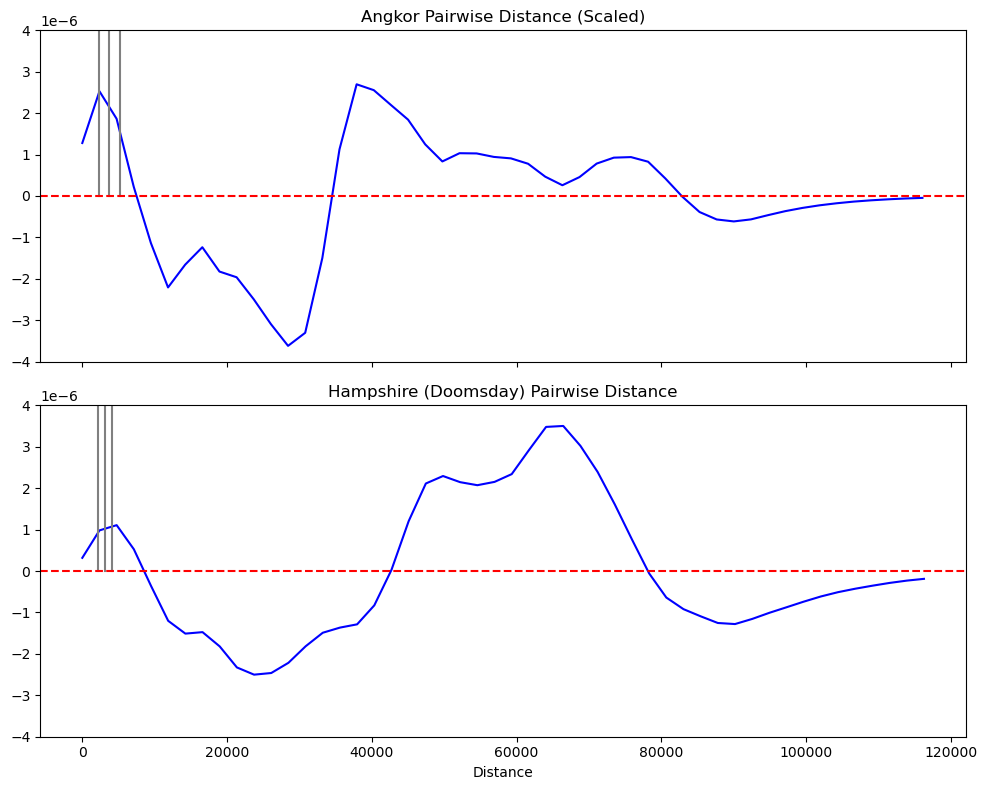

In [228]:
import numpy as np  # Import NumPy for array manipulation
from matplotlib.gridspec import GridSpec

# Define the scaling ratio for the x-axis
scaling_ratio = 1.5  # Example ratio, replace with your value

# Create a new figure for combining
combined_pdd_fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, figure=combined_pdd_fig, height_ratios=[1, 1])

# Add the first plot with scaled x-data
ax_combined_1 = combined_pdd_fig.add_subplot(gs[0, 0])
for line in saved_fig_angkor.axes[0].get_lines():
    scaled_x = np.array(line.get_xdata()) * scaling_ratio  # Apply scaling
    ax_combined_1.plot(scaled_x, line.get_ydata(), color=line.get_color())
ax_combined_1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_combined_1.set_title("Angkor Pairwise Distance (Scaled)")
ax_combined_1.set_ylim([-4e-6, 4e-6])  # Set y-axis limits

# Add the second plot without scaling
ax_combined_2 = combined_pdd_fig.add_subplot(gs[1, 0], sharex=ax_combined_1)  # Share x-axis with the first plot
for line in saved_fig_dooms.axes[0].get_lines():
    ax_combined_2.plot(line.get_xdata(), line.get_ydata(), color=line.get_color())
ax_combined_2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax_combined_2.set_title("Hampshire (Doomsday) Pairwise Distance")
ax_combined_2.set_ylim([-4e-6, 4e-6])  # Set y-axis limits

# Ensure the x-axis is labeled only at the bottom plot
ax_combined_1.tick_params(labelbottom=False)  # Turn off x-axis labels for the top plot
ax_combined_2.set_xlabel("Distance")

# Display the combined figure
plt.tight_layout()
plt.show()


## First Peaks

In [201]:
from scipy.signal import find_peaks
import warnings

def find_first_peak(pdd_slice, support):
    """
    Finds the first peak in a PDD slice.

    Parameters:
    -----------
    pdd_slice : np.ndarray
        A 1D array of PDD values for a single realization.
    support : np.ndarray
        Array of distance values (x-axis).

    Returns:
    --------
    float
        Distance (x-coordinate) of the first peak.
    """
    # Find all peaks in the PDD slice
    peaks, _ = find_peaks(pdd_slice)

    # If peaks exist, return the first one
    if len(peaks) > 0:
        return support[peaks[0]]

    # If no peaks are found, return NaN
    return np.nan

def find_all_first_peaks(diff_array, support, time_slice_idx):
    """
    Finds the first peak for all realizations in a PDD difference array and returns 
    both the peak locations and their corresponding densities.

    Parameters:
    -----------
    diff_array : np.ndarray
        3D array of PDD difference values (distances x time_slices x realizations).
    support : np.ndarray
        Array of distance values (x-axis).
    time_slice_idx : int
        Index of the time slice to analyze.

    Returns:
    --------
    peaks : list
        List of first peak locations for all realizations.
    densities : list
        List of density values at the first peak for all realizations.
    """
    peaks = []
    densities = []
    num_realizations = diff_array.shape[2]

    for realization_idx in range(num_realizations):
        # Extract the PDD slice for the current realization
        pdd_slice = diff_array[:, time_slice_idx, realization_idx]

        # Find the first peak location
        peak_location = find_first_peak(pdd_slice, support)
        
        # if no peak, just return nan
        if np.isnan(peak_location):
            warnings.warn("No peak found.", UserWarning)
            peaks.append(np.nan)
            densities.append(np.nan)
        else:
            # Get the density value at the peak
            peak_density = pdd_slice[support == peak_location][0]  # Find density at the peak

            # Append results
            peaks.append(peak_location)
            densities.append(peak_density)

    return np.array(peaks), np.array(densities)


### Set Common Parameters

In [203]:
num_iterations = 500 # sets the number of draws for incorporating chronological uncertainty
# set consistent pairwise bandwidth (binning of distances)
use_kde = True
pair_bw = None
kde_sample_n = 100
kde_custom=cuml_kde
max_distance = 15000

### Angkor First Peak


In [204]:
time_slice = 1100

# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations = clustering.mc_samples(points, 
                                    time_slices=[time_slice],  
                                    num_iterations=num_iterations)

# Produce pairwise distances to explore clustering structure
pairwise_density_angkor, support_angkor = clustering.temporal_pairwise(simulations, 
                                                         [time_slice],
                                                         bw=pair_bw, 
                                                         use_kde=use_kde, 
                                                         kde_sample_n=kde_sample_n,
                                                         max_distance=max_distance,
                                                         kde_custom=kde_custom)

# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(points, 
                                         [time_slice], 
                                         num_iterations=num_iterations,
                                         null_model=clustering.bise)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density_angkor, bise_support_angkor = clustering.temporal_pairwise(bise_simulations, 
                                                                 [time_slice], 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array_angkor, diff_array_angkor = clustering.p_diff(pairwise_density_angkor, bise_pairwise_density_angkor)

In [205]:
p_pdd_peaks_angkor, _ = find_all_first_peaks(diff_array_angkor, support_angkor, 0)

# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(p_pdd_peaks_angkor, columns=["Values"]).describe()

# Display the summary statistics
summary_stats


,Values
count,500.000000
mean,1744.545455
std,295.412072
min,1060.606061
25%,1515.151515
50%,1666.666667
75%,1969.696970
max,2878.787879


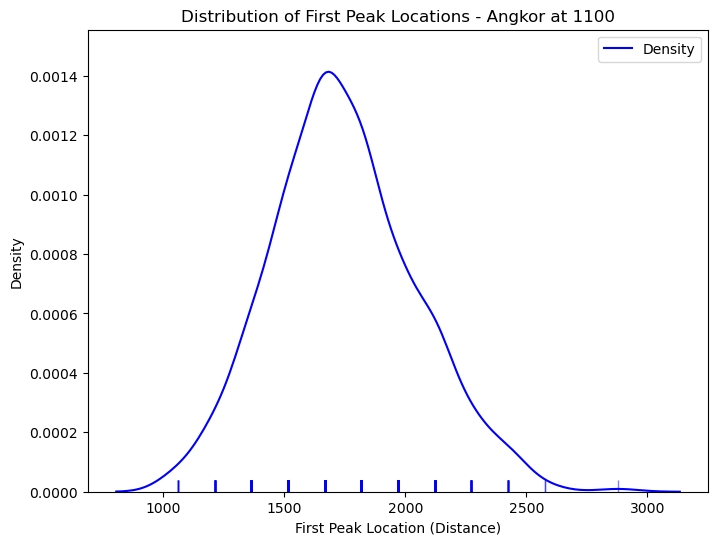

In [206]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_angkor, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_angkor, color='blue', alpha=0.5)  # Semi-transparent rug ticks

# Add labels and title
plt.xlabel("First Peak Location (Distance)")
plt.ylabel("Density")
plt.title(f"Distribution of First Peak Locations - Angkor at {time_slice}")
plt.legend()

# Show the plot
plt.show()

### Hampshire First Peak

In [220]:
time_slice = 1066

# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations = clustering.mc_samples(doomsday_points, 
                                    time_slices=[time_slice],  
                                    num_iterations=num_iterations)

# Produce pairwise distances to explore clustering structure
pairwise_density_hampshire, support_hampshire = clustering.temporal_pairwise(simulations, 
                                                         [time_slice],
                                                         bw=pair_bw, 
                                                         use_kde=use_kde, 
                                                         kde_sample_n=kde_sample_n,
                                                         max_distance=max_distance,
                                                         kde_custom=kde_custom)

# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(doomsday_points, 
                                         [time_slice], 
                                         num_iterations=num_iterations,
                                         null_model=clustering.bise)

# Calulate the pairwise distances for the BISE sample
bise_pairwise_density_hampshire, bise_support_hampshire = clustering.temporal_pairwise(bise_simulations, 
                                                                 [time_slice], 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde,
                                                                 kde_sample_n=kde_sample_n, 
                                                                 max_distance = max_distance,
                                                                 kde_custom=kde_custom)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array_hampshire, diff_array_hampshire = clustering.p_diff(pairwise_density_hampshire, bise_pairwise_density_hampshire)

In [222]:
p_pdd_peaks_hampshire, _ = find_all_first_peaks(diff_array_hampshire, support_hampshire, 0)

# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(p_pdd_peaks_hampshire, columns=["Values"]).describe()

# Display the summary statistics
summary_stats

,Values
count,500.000000
mean,3802.424242
std,383.173854
min,2575.757576
25%,3636.363636
50%,3787.878788
75%,4090.909091
max,4848.484848


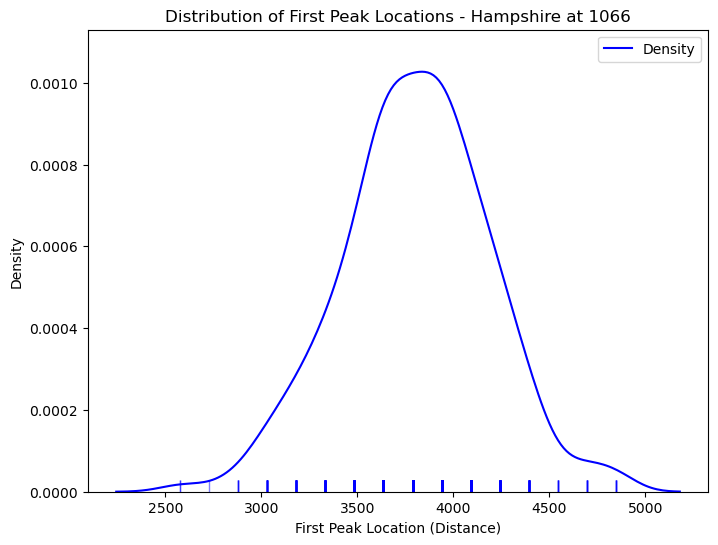

In [223]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_hampshire, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_hampshire, color='blue', alpha=0.5)  # Semi-transparent rug ticks

# Add labels and title
plt.xlabel("First Peak Location (Distance)")
plt.ylabel("Density")
plt.title(f"Distribution of First Peak Locations - Hampshire at {time_slice}")
plt.legend()

# Show the plot
plt.show()

### Difference Distribution

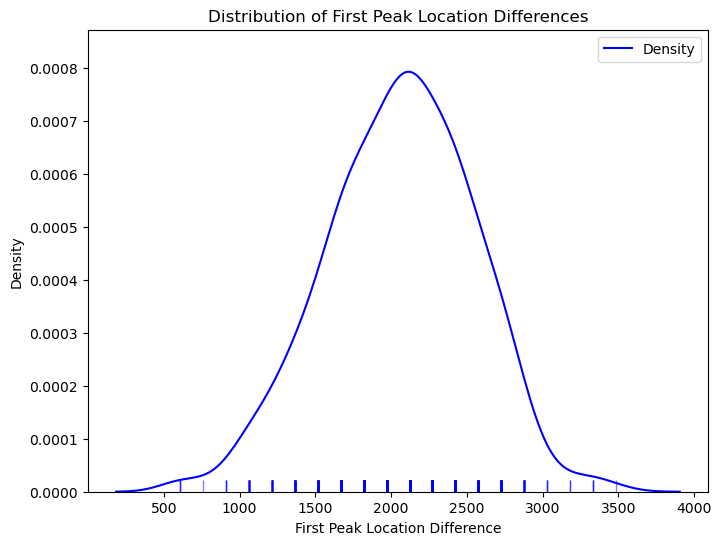

In [225]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_hampshire - p_pdd_peaks_angkor, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_hampshire - p_pdd_peaks_angkor, color='blue', alpha=0.5)  # Semi-transparent rug ticks

# Add labels and title
plt.xlabel("First Peak Location Difference")
plt.ylabel("Density")
plt.title("Distribution of First Peak Location Differences")
plt.legend()

# Show the plot
plt.show()

In [226]:
# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(p_pdd_peaks_hampshire / p_pdd_peaks_angkor, columns=["Values"]).describe()

# Display the summary statistics
summary_stats

,Values
count,500.000000
mean,2.244476
std,0.456906
min,1.210526
25%,1.923077
50%,2.181818
75%,2.500000
max,4.142857


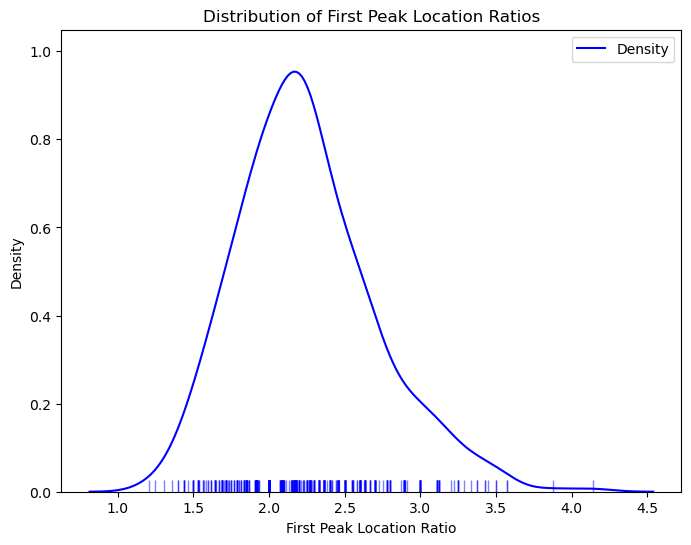

In [229]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_hampshire / p_pdd_peaks_angkor, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_hampshire / p_pdd_peaks_angkor, color='blue', alpha=0.5)  # Semi-transparent rug ticks

# Add labels and title
plt.xlabel("First Peak Location Ratio")
plt.ylabel("Density")
plt.title("Distribution of First Peak Location Ratios")
plt.legend()

# Show the plot
plt.show()